In [10]:
%matplotlib inline
from matplotlib import pyplot as plt
import torch
import numpy as np
import imageio
import os
import csv
import torch.optim as optim

# 5장 - 학습 기법

In [11]:
# 머신러닝의 구체적인 동작 방식과 알고리즘
# 관찰자 입장에서 학습 알고리즘은 입력과 이에 대응하는 출력 쌍으로 표현됨
# 학습 때의 입력 데이터와 충분히 유사한 새로운 데이터 들어오면 정확한 출력 만들며 출력 형태가 입력 형태와 현저하게 달라도 동작함 ex) 이미지 입력받고 설명하는 문장 출력

## 1절 - 시대를 초월하는 모델링 학습

In [12]:
# 케플러가 업적 이뤄낸 과정 요약
# 1. 좋은 데이터 얻기
# 2. 수상한 점을 가시화하려 노력하기
# 3. 데이터에 가장 잘 부합할 만한 최대한 단순한 모델 고르기
# 4. 데이터 쪼개서 일부는 사용 나머지는 검증을 위해 남겨두기
# 5. 잠정적으로 파라미터 정하고 모델이 관찰 결과와 맞을 때까지 반복
# 6. 별도의 관찰로 자신의 모델 검증
# 7. 의심스러운 부분 되돌아보기

In [13]:
# 위의 과정이 데이터에 맞춰(fitting) 가는 과정과 데이터로부터 학습(learning)하는 알고리즘 만드는 과정
# 데이터로부터 평가되는 알 수 없는 파라미터 가진 함수가 있음을 전제 -> 이러한 함수를 모델이라고 함

In [14]:
# 데이터로 배운다는 것은 기반 모델이 특정 문제를 풀기 위해 만들어진 것이 아님을 전제

In [15]:
# 입출력 쌍을 활용한 다양한 유사 작업에 대해 스스로를 자동으로 최적화하는 모델 -> 특정 작업에 대한 데이터로 학습한 일반화된 모델
# 파이토치는 파라미터 관점에서 잔차(fitting error = residual)의 미분을 분석적으로 표현하기 위한 모델을 쉽게 생성하도록 설계됨

In [16]:
# 이번 장은 딥러닝의 핵심인 일반 함수의 fitting을 자동화하는 방법을 다룸
# 심층 신경망(NN)이 바로 일반 함수이며 파이토치는 이 과정을 최대한 단순하고 투명하게 만들어줌

## 2절 - 학습은 파라미터 추정에 불과하다

In [17]:
# 계측 조정
# 입출력에 해당하는 실측 자료와 가중치 초깃값이 주어졌을 때
# 1. 모델에 입력 데이터 들어가고(순방향 전달)
# 2. 실측값과 출력 결괏값을 비교해서 오차 계산
# 3. 파라미터 최적화 위해 가중치를 오차값에 따라 일정 단위만큼(gradient 의미) 변경 변경값은 합성 함수(역방향 전달)의 미분값을 연속으로 계산하는 규칙(chain rule)을 통해 결정
# 위를 학습 때 사용하지 않은 데이터에 대한 출력값과 실측값과의 오류가 일정 수준 이하로 떨어질 때까지 반복

In [18]:
# 데이터 수집 t_c는 섭씨 온도 값 t_u는 우리가 모르는 단위의 값 / 두 값은 약간의 노이즈가 있는 측정값
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)

In [19]:
# 데이터 시각화: 선형 모델을 따를 것으로 생각됨 그림 5.3 참조

In [20]:
# 답을 모른다고 가정하고 두 측정 값 사이에서 변환하는 역할할 모델로 선형 관계 선정 -> t_u에 w 곱하고 b 더하면 섭씨 단위 온도값 얻을 것으로 예상
# t_u로 나타난 선이 여러 번의 측정으로 맞춰가는 것 같다면 정확하게 구현한 것

In [21]:
# 알 수 없는 파라미터 가진 모델이 있고 파라미터 값 추정해서 측정된 값과 예측값인 출력값 사이의 오차가 작아지게 만드는 것
# 손실 함수(loss function)라 불리는 측정 함수 만들되 오차 높으면 함수 출력값도 정의하여 완벽하게 일치할 때 출력값 가장 작게
# 손실 함수 값 최소인 지점에서 w와 b 찾는게 최적화 과정

## 3절 - 손실을 줄이기 위한 방안

In [22]:
# 학습 과정이 최소화하고자 하는 단일 값을 계산하는 손실 함수(= 비용 함수)
# 일반적으로 훈련 샘플로부터 기대하는 출력값과 모델이 샘플에 대해 실제 출력한 값 사이의 차이
# 항상 양수의 차이가 나도록 오차에 절대값이나 제곱을 씌움
# 사용하는 형태에 따라 특정 오차를 강조하거나 무시하게 됨
# 개념적으로 손실 함수는 오차 중 어떤 경우를 우선해서 보완할 것인지 결정함 즉 가중치가 큰 샘플을 우선적으로 보정함

In [23]:
# 두 손실 함수 모두 최소 오차는 0, 어느 방향이든 예측값이 실젯값보다 커치면 오차도 단조적으로 증가
# 그래프의 상승 기울기 역시 최솟값으로부터 단조적으로 증가하므로 둘 다 볼록(convex)
# 모델이 선형이므로 손실 함수 역시 볼록함
# 손실이 모델 파라미터의 볼록 함수인 경우는 특수 알고리즘을 통해 효과적으로 최솟값 찾을 수 있으므로 다루기 좋음
# 이보다는 덜 강력하지만 더 일반적으로 적용 가능한 방식을 사용할 예점 -> nn의 손실 그래프는 입력에 대한 볼록 함수가 아니기 때문

In [24]:
# 차이값이 0 일 때, 절대값 사용한 경우에는 미분값을 정의 못하므로 제곱을 사용

In [25]:
# 제곱 사용한 차이가 절대값 사용한 차이보다 잘못된 결과에 더 많은 불이익을 줌
# 대부분 조금 틀린 값이 많이 나오는 편이 완전 틀린 값이 어느 정도 나올 때보다 바란직한데, 제곱 사용한 경우는 오차 보정에 우선순위 주도록 동작함

In [26]:
# 파이썬 함수로 모델을 작성
def model(t_u, w, b):
    return w * t_u + b

In [27]:
# 손실 함수 작성
# 손실을 제곱하고 평균내서 '평균 제곱 손실(mean square loss)'라고 함
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

In [28]:
# 파라미터 초기화 및 모델 호출
w = torch.ones(())
b = torch.zeros(())
t_p = model(t_u, w, b)
t_p

tensor([35.7000, 55.9000, 58.2000, 81.9000, 56.3000, 48.9000, 33.9000, 21.8000,
        48.4000, 60.4000, 68.4000])

In [29]:
# 손실값 확인
loss = loss_fn(t_p, t_c)
loss

tensor(1763.8848)

## 4절 - 경사를 따라 내려가기

In [30]:
# 경사 하강(gradient descent) 알고리즘 사용해 손실 함수 최적화
# 각 파라미터와 관련해 손실의 변화율을 계산해 손실이 줄어드는 방향으로 파라미터 값 변경
# w, b의 값을 아주 조금 늘리거나 줄여서 그 사이에 손실값이 얼마나 변하는지 확인하는 것
delta = 0.1

loss_rate_of_change_w = (loss_fn(model(t_u, w + delta, b), t_c) - loss_fn(model(t_u, w - delta, b), t_c)) / (2.0 * delta)

In [31]:
# 위 코드는 현재 w, b 값에서 특정 단위만큼 w가 증가했을 때의 손실이 변하게 만듦
# 값이 줄어들면 w 더 늘려서 손실을 최소화, 값이 늘어나면 w 줄여서 손실을 최소화시킴
# 손실의 변화 비율에 비례해 w 변경하는 것이 좋음
# 손실값의 변화에 영향을 많이 미치는 파라미터를 변경
# 현재 w값 근방에서 떨어진 곳에서는 변화율이 급격할 수 있으므로 파라미터 값도 서서히 변경하는 것이 좋음
# 이 스케일링 비율을 보통 learning_rate라고 함

In [32]:
learning_rate = 1e-2

w = w - learning_rate * loss_rate_of_change_w

In [33]:
# b도 동일하게 함
loss_rate_of_change_b = loss_rate_of_change_w = (loss_fn(model(t_u, w, b + delta), t_c) - loss_fn(model(t_u, w, b - delta), t_c)) / (2.0 * delta)

b = b - learning_rate * loss_rate_of_change_b

In [34]:
# 위는 경사 하강에서 기본적인 파라미터 조정을 표현
# 이런 식의 평가를 반복하여 주어진 데이터에 대해 손실 계산값이 최소로 떨어지는 최적의 파라미터 값으로 수렴하게 됨
# 지금 변화율이 너무 심해서 조정할 필요가 있음 왜 그런지 어떻게 하는지 알아볼 것

In [35]:
# 위와 같은 방식을 파라미터가 많은 모델로 확장하기 어렵고 인접 영역을 얼마의 거리로 볼 것인지 규정하기도 어려움
# delta를 극단적으로 줄이면 손실 함수를 미분하는 것과 일치함
# 두 개 이상의 파라미터 가진 모델에서는 각 파라미터에 대한 손실 함수의 편미분 구하고 이 값들을 미분 벡터에 넣음

In [36]:
# 연쇄 규칙을 적용하여 입력(모델의 출력값)에 대한 손실 함수의 미분을 계산해 미라미터에 대한 모델의 미분 곱하기
# d loss_fn / d w = (d loss_fn / d t_p) * (d t_p / d w)
# 위에 작성한 모델은 선형 함수고 손실 함수는 제곱의 합임
# d x^2 / d x = 2 x 임을 이용
def dloss_fn(t_p, t_c):
    dsq_diffs = 2 * (t_p - t_c) / t_p.size(0) # 평균의 도함수로 나눔
    return dsq_diffs

In [37]:
# 아래와 같이 함수를 정의해서 모델의 미분 구하기
def dmodel_dw(t_u, w, b):
    return t_u

def dmodel_db(t_u, w, b):
    return 1.0

In [38]:
# 모두 합쳐서 w와 b에 대한 손실값의 미분을 반환하는 함수 만들기
def grad_fn(t_u, t_c, t_p, w, b):
    dloss_dtp = dloss_fn(t_p, t_c)
    dloss_dw = dloss_dtp * dmodel_dw(t_u, w, b)
    dloss_db = dloss_dtp * dmodel_db(t_u, w, b)
    return torch.stack([dloss_dw.sum(), dloss_db.sum()]) # 합 계산은 파라미터를 모델의 전체 입력 벡터에 대해 적용하던 브로드캐스팅의 역순

In [39]:
# 파라미터를 위한 임시 값에서 출발해 고정된 횟수만큼 반복하며 w와 b가 변하지 않을 때까지 조정
# 훈련 샘플을 가지고 반복적으로 파라미터를 조정하는 훈련의 한 단위를 에포크(epoch)라고 부름
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        w, b = params

        t_p = model(t_u, w, b) # 순방향 전달
        loss = loss_fn(t_p, t_c)
        grad = grad_fn(t_u, t_c, t_p, w, b) # 역방향 전달

        params = params - learning_rate * grad

        print('Epoch %d, Loss %f' % (epoch, float(loss)))
        print('  Params: {}'.format(params))
        print('  Grad:   {}'.format(grad))

    return params

In [40]:
# 훈련 루프 실행
training_loop(n_epochs = 100, learning_rate = 1e-2, params = torch.tensor([1.0, 0.0]), t_u = t_u, t_c = t_c)

Epoch 1, Loss 1763.884766
  Params: tensor([-44.1730,  -0.8260])
  Grad:   tensor([4517.2964,   82.6000])
Epoch 2, Loss 5802484.500000
  Params: tensor([2568.4011,   45.1637])
  Grad:   tensor([-261257.4062,   -4598.9702])
Epoch 3, Loss 19408029696.000000
  Params: tensor([-148527.7344,   -2616.3931])
  Grad:   tensor([15109614.0000,   266155.6875])
Epoch 4, Loss 64915905708032.000000
  Params: tensor([8589999.0000,  151310.8906])
  Grad:   tensor([-8.7385e+08, -1.5393e+07])
Epoch 5, Loss 217130525461053440.000000
  Params: tensor([-4.9680e+08, -8.7510e+06])
  Grad:   tensor([5.0539e+10, 8.9023e+08])
Epoch 6, Loss 726257583152928129024.000000
  Params: tensor([2.8732e+10, 5.0610e+08])
  Grad:   tensor([-2.9229e+12, -5.1486e+10])
Epoch 7, Loss 2429183416467662896627712.000000
  Params: tensor([-1.6617e+12, -2.9270e+10])
  Grad:   tensor([1.6904e+14, 2.9776e+12])
Epoch 8, Loss 8125122549611731432050262016.000000
  Params: tensor([9.6102e+13, 1.6928e+12])
  Grad:   tensor([-9.7764e+15, -1

tensor([nan, nan])

In [41]:
# 위와 같은 발산 막기 위해 learning_rate * grad 적절하게 제한
# 일반적으로 바꿔 보기 쉬운 값인 learning_rate 값 조절
# learning_rate 값 1e-4로 수정
training_loop(n_epochs = 100, learning_rate = 1e-4, params = torch.tensor([1.0, 0.0]), t_u = t_u, t_c = t_c)

Epoch 1, Loss 1763.884766
  Params: tensor([ 0.5483, -0.0083])
  Grad:   tensor([4517.2964,   82.6000])
Epoch 2, Loss 323.090515
  Params: tensor([ 0.3623, -0.0118])
  Grad:   tensor([1859.5493,   35.7843])
Epoch 3, Loss 78.929634
  Params: tensor([ 0.2858, -0.0135])
  Grad:   tensor([765.4666,  16.5122])
Epoch 4, Loss 37.552845
  Params: tensor([ 0.2543, -0.0143])
  Grad:   tensor([315.0790,   8.5787])
Epoch 5, Loss 30.540283
  Params: tensor([ 0.2413, -0.0149])
  Grad:   tensor([129.6733,   5.3127])
Epoch 6, Loss 29.351154
  Params: tensor([ 0.2360, -0.0153])
  Grad:   tensor([53.3495,  3.9682])
Epoch 7, Loss 29.148884
  Params: tensor([ 0.2338, -0.0156])
  Grad:   tensor([21.9304,  3.4148])
Epoch 8, Loss 29.113848
  Params: tensor([ 0.2329, -0.0159])
  Grad:   tensor([8.9964, 3.1869])
Epoch 9, Loss 29.107145
  Params: tensor([ 0.2325, -0.0162])
  Grad:   tensor([3.6721, 3.0930])
Epoch 10, Loss 29.105247
  Params: tensor([ 0.2324, -0.0166])
  Grad:   tensor([1.4803, 3.0544])
Epoch 11

tensor([ 0.2327, -0.0438])

In [42]:
# 파라미터 조정이 너무 작아 손실이 덜 줄어듦 -> learning_rate를 조정 규모에 따라 변하는 적응형으로 만들어 방지 가능(최적화 전략)

In [43]:
# learning_rate 외에 grad가 문제 일으킬 수 있음
# 1 epoch에서 가중치에 대한 기울기가 편향값에 대한 기울기의 50배 큼
# 하나를 조정하기에 적절한 크기의 학습률은 다른 값의 업데이트 불안정하게 만들 수 있음
# 입력값을 변경하여 기울기가 서로 큰 차이가 나지 않게 만들면 됨
# 입력값의 범위가 [-1.0, 1.0]이면 가능해짐
# 예제에서는 t_u에 0.1 곱하면 유사하게 됨
t_un = 0.1 * t_u # 정규화 의미하는 n을 변수 이름에 붙임

In [44]:
# 훈련 루프
training_loop(n_epochs = 100, learning_rate = 1e-2, params = torch.tensor([1.0, 0.0]), t_u = t_un, t_c = t_c)

Epoch 1, Loss 80.364342
  Params: tensor([1.7761, 0.1064])
  Grad:   tensor([-77.6140, -10.6400])
Epoch 2, Loss 37.574913
  Params: tensor([2.0848, 0.1303])
  Grad:   tensor([-30.8623,  -2.3864])
Epoch 3, Loss 30.871077
  Params: tensor([2.2094, 0.1217])
  Grad:   tensor([-12.4631,   0.8587])
Epoch 4, Loss 29.756193
  Params: tensor([2.2616, 0.1004])
  Grad:   tensor([-5.2218,  2.1327])
Epoch 5, Loss 29.507153
  Params: tensor([2.2853, 0.0740])
  Grad:   tensor([-2.3715,  2.6310])
Epoch 6, Loss 29.392456
  Params: tensor([2.2978, 0.0458])
  Grad:   tensor([-1.2492,  2.8241])
Epoch 7, Loss 29.298828
  Params: tensor([2.3059, 0.0168])
  Grad:   tensor([-0.8071,  2.8970])
Epoch 8, Loss 29.208717
  Params: tensor([ 2.3122, -0.0124])
  Grad:   tensor([-0.6325,  2.9227])
Epoch 9, Loss 29.119415
  Params: tensor([ 2.3178, -0.0417])
  Grad:   tensor([-0.5633,  2.9298])
Epoch 10, Loss 29.030489
  Params: tensor([ 2.3232, -0.0710])
  Grad:   tensor([-0.5355,  2.9295])
Epoch 11, Loss 28.941877
  

tensor([ 2.7553, -2.5162])

In [45]:
# epoch 키워서 훈련 루프
params = training_loop(n_epochs = 5000, learning_rate = 1e-2, params = torch.tensor([1.0, 0.0]), t_u = t_un, t_c = t_c)
params

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  Params: tensor([  5.3570, -17.2442])
  Grad:   tensor([-0.0018,  0.0103])
Epoch 3335, Loss 2.927967
  Params: tensor([  5.3570, -17.2443])
  Grad:   tensor([-0.0018,  0.0103])
Epoch 3336, Loss 2.927967
  Params: tensor([  5.3571, -17.2444])
  Grad:   tensor([-0.0018,  0.0103])
Epoch 3337, Loss 2.927963
  Params: tensor([  5.3571, -17.2446])
  Grad:   tensor([-0.0018,  0.0102])
Epoch 3338, Loss 2.927963
  Params: tensor([  5.3571, -17.2447])
  Grad:   tensor([-0.0018,  0.0102])
Epoch 3339, Loss 2.927962
  Params: tensor([  5.3571, -17.2448])
  Grad:   tensor([-0.0018,  0.0102])
Epoch 3340, Loss 2.927962
  Params: tensor([  5.3571, -17.2449])
  Grad:   tensor([-0.0018,  0.0102])
Epoch 3341, Loss 2.927960
  Params: tensor([  5.3572, -17.2450])
  Grad:   tensor([-0.0018,  0.0102])
Epoch 3342, Loss 2.927960
  Params: tensor([  5.3572, -17.2451])
  Grad:   tensor([-0.0018,  0.0102])
Epoch 3343, Loss 2.927959
  Params: tensor([  5.3572, -17.2452])
  Grad:

tensor([  5.3671, -17.3012])

In [46]:
# 손실이 0이 아닌 것은 반복 횟수 부족 혹은 데이터가 선분에 정확하게 걸치지 않아서 혹은 값을 부정확하게 읽어서 노이즈 발생으로 인한 것일 수 있음
# 훈련으로 알아낸 값은 실제 정답인 w = 5.5556, b = -17.7778에 유사

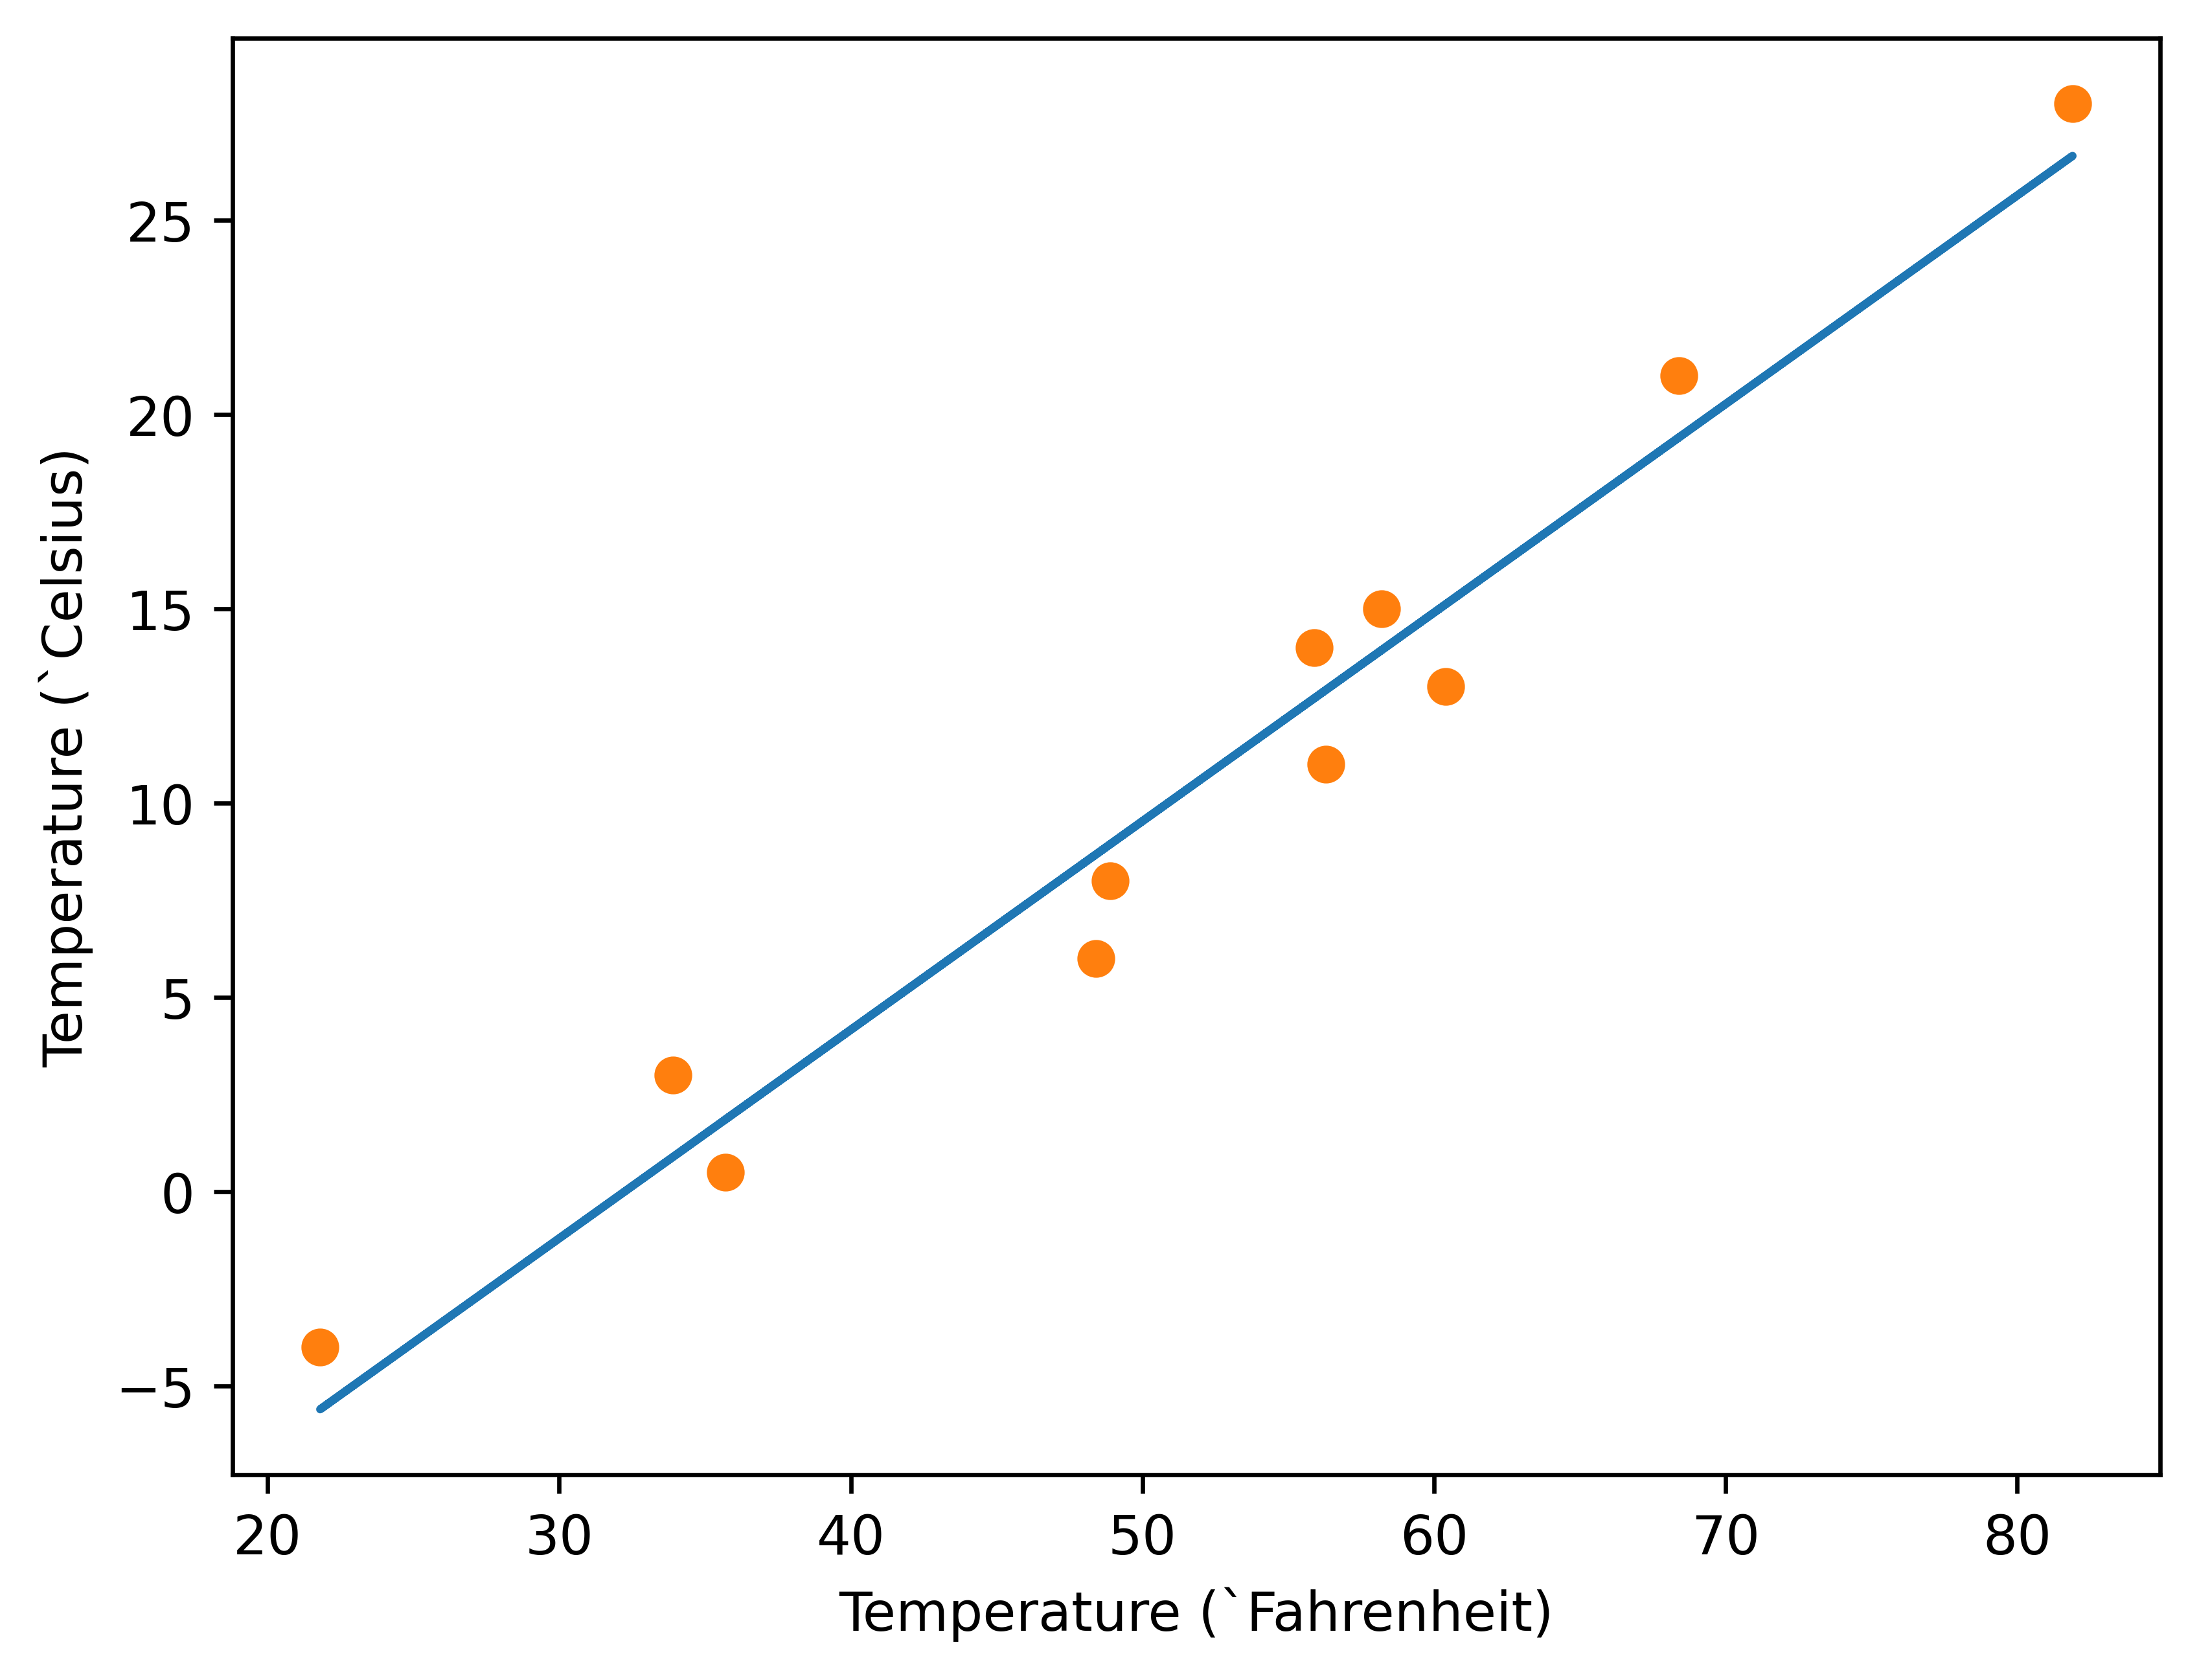

In [47]:
# 시각화
%matplotlib inline
from matplotlib import pyplot as plt

t_p = model(t_un, *params) # 단위 모르는 값을 정규화 하여 훈련, 인자 언패킹
fig = plt.figure(dpi = 600)
plt.xlabel("Temperature (`Fahrenheit)")
plt.ylabel("Temperature (`Celsius)")
plt.plot(t_u.numpy(), t_p.detach().numpy()) # 알 수 없는 원본 값 그리기
plt.plot(t_u.numpy(), t_c.numpy(), 'o')

## 5절 - 파이토치의 자동미분: 모든 것을 역전파하라

In [48]:
# 연쇄 규칙을 사용하여 미분을 역방향으로 전파하는 방법의 기본 전제는 다루는 모든 함수가 해석적으로 미분 가능해야 함
# 미분 가능하면 gradient 계산 빠르게 가능

In [49]:
# 파이토치 텐서는 자신이 어떤 연산을 수행해서 만들어진 텐서인지 기억하며 미분을 최초 입력까지 연쇄적으로 적용해 올라갈 수 있음
# 순방향 식만 주어지면 파이토치는 기울기를 자동 제공함

In [50]:
# 자동미분 사용하여 온도계 보정 코드 다시 작성하고 동작 확인

In [51]:
# 손실 함수, 모델 및 파라미터 텐서 다시 초기화

def model(t_u, w, b):
    return w * t_u + b

def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

params = torch.tensor([1.0, 0.0], requires_grad=True)

In [52]:
# requires_grad=True 인자가 params에 가해지는 연산의 결과로 만들어지는 모든 텐서를 이은 전체 트리를 기록하도록 파이토치에게 요청
# params를 조상으로 두는 모든 텐서는 params로부터 해당 텐서가 만들어지기까지 그 사이에 있는 모든 함수에 접근할 권한을 가짐
# 이 함수들이 미분 가능한 경우(대부분의 파이토치 텐서 연산) 미분값은 params 텐서의 grad 속성으로 자동 기록됨

In [53]:
# 일반적으로 모든 파이토치 텐서는 grad 속성을 가짐 defalut는 None
params.grad is None

True

In [54]:
# 이 값 얻기 위해서는 텐서 만들 때 requires_grad를 True로 지정, 모델 호출해 손실값 구한 다음 loss 텐서에 대해 backward 호출
loss = loss_fn(model(t_u, *params), t_c)
loss.backward()

params.grad

tensor([4517.2969,   82.6000])

In [55]:
# params의 grad는 params의 각 요소에 대한 손실값의 미분 포함함

In [56]:
# loss 계산할 때, 실제 계산을 수행하는 이외에 파라미터 w, b가 기울기 요구하는 경우 파이토치는 연산을 노드로 하는 자동미분 그래프 생성
# 이후 loss.backward() 호출할 때, 파이토치는 그래프를 거꾸로 따라가면서 기울기를 계산

In [57]:
# 텐서 수가 몇 개든 함수 합성이 다양하든 requires_grad=True로 설정 가능
# 파이토치는 연쇄적으로 연결된 함수들을 거쳐 손실에 대한 미분을 계산하고 값을 텐서의 grad 속성에 "누적"함
# 따라서 앞에 backward가 호출 되었다면 손실이 다시 계산되고 backward가 다시 호출되고 각 말단 노드의 기울기 값이 이전 반복문 수행 시 계산되었던 값에 누적되어 부정확한 기울기값 초래함
# 이를 방지하기 위해 각 반복문에서 명시적으로 기울기를 0으로 초기화 해야 함 -> zero_ 메소드로 간단하게 초기화
if params.grad is not None:
    params.grad.zero_()

In [58]:
# 자동미분 적용한 훈련 코드
def training_loop(n_epochs, learning_rate, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        if params.grad is not None:
            params.grad.zero_()

        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
        loss.backward()

        with torch.no_grad():
            params -= learning_rate * params.grad

        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))

    return params

In [59]:
# 코드의 두 가지 특징
# 1. with으로 파라미터 조정이 no_grad 안에서 진행되어 파이토치 자동미분 기능이 신경쓰지 않음 -> 순방향 그래프에 부가적인 엣지 더할 필요 없음
# 2. params텐서 유지하며 덮어쓰며 조정함
#    자동미분 사용하면 역방향 전달시 변수 값 바꿔야 할 수 있으므로 값을 덮어쓰며 조정하지 않음   # 자동미분 적용한 훈련 코드인데 자동미분 없이 동작한다고 함
training_loop(n_epochs = 5000, learning_rate = 1e-2, params = torch.tensor([1.0, 0.0], requires_grad=True), t_u = t_un, t_c = t_c)

Epoch 500, Loss 7.860115
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957698
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927679
Epoch 4500, Loss 2.927652
Epoch 5000, Loss 2.927647


tensor([  5.3671, -17.3012], requires_grad=True)

In [60]:
# torch에는 optim 서브 모듈로 다양한 최적화 알고리즘 구현 클래스 지원

In [61]:
# 최적화 알고리즘 리스트
import torch.optim as optim

dir(optim)

['ASGD',
 'Adadelta',
 'Adagrad',
 'Adam',
 'AdamW',
 'Adamax',
 'LBFGS',
 'NAdam',
 'Optimizer',
 'RAdam',
 'RMSprop',
 'Rprop',
 'SGD',
 'SparseAdam',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_functional',
 '_multi_tensor',
 'lr_scheduler',
 'swa_utils']

In [62]:
# optim 생성자는 첫 입력으로 파라미터 리스트(통상 requires_gradrk True인 텐서)를 받음
# optim에 전달된 파라미터는 옵티마이저 객체 내부에 유지되고, 그림처럼 값을 조정하고 grad 속성에 접근할 때 사용됨
# optim은 zero-grad와 step이라는 두 가지 메소드 제공
# zero_grad는 옵티마이저 생성자에 전되됐던 파라미터의 grad 값 0으로 변경
# step은 옵티마이져별로 구현된 최적화 전략에 따라 파라미터 값 조정

In [63]:
# params 만들고 경사 하강 옵티마이저 인스턴스 생성
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-5
optimizer = optim.SGD([params], lr=learning_rate)

In [64]:
# SGD(확률적 경사 하강, stochastic gradient descent)은 momentum이 0.0으로 설정됐을 때 순정 버전의 경사 하강과 동일
# SGD의 기울기는 미니배치라고 불리는 샘플 중 임의로 뽑은 일부로 대해 평균을 계산하여 확률적이라고 불림
# 옵티마이저는 손실값이 순정인지 확률적인 것인지 모르기 때문에 알고리즘적으로 동일

In [65]:
# 옵티마이저 사용
t_p = model(t_u, *params)
loss = loss_fn(t_p, t_c)
loss.backward()

optimizer.step() # params 자동 조정

params

tensor([ 9.5483e-01, -8.2600e-04], requires_grad=True)

In [66]:
# 옵티마이저는 params.grad 보고 parmas에서 grad에 learning_rate 곱한 것 만큼 빼서 조정

In [67]:
# zero_grad 추가
params= torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

t_p = model(t_un, *params)
loss = loss_fn(t_p, t_c)

optimizer.zero_grad()
loss.backward()
optimizer.step()

params

tensor([1.7761, 0.1064], requires_grad=True)

In [72]:
# 파라미터 리스트 전달하도록 훈련 루프 수정
def training_loop(n_epochs, optimizer, params, t_u, t_c):
    for epoch in range(1, n_epochs + 1):
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if epoch % 500 == 0:
            print('Epoch %d, Loss %f' % (epoch, float(loss)))

    return params

In [73]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)

training_loop(n_epochs = 5000, optimizer = optimizer, params = params, t_u = t_un, t_c = t_c)

Epoch 500, Loss 7.860120
Epoch 1000, Loss 3.828538
Epoch 1500, Loss 3.092191
Epoch 2000, Loss 2.957698
Epoch 2500, Loss 2.933134
Epoch 3000, Loss 2.928648
Epoch 3500, Loss 2.927830
Epoch 4000, Loss 2.927679
Epoch 4500, Loss 2.927652
Epoch 5000, Loss 2.927647


tensor([  5.3671, -17.3012], requires_grad=True)

In [74]:
# optim에서 adam 사용
# 학습률이 동적으로 변하는 섬세한 옵티마이저
# 파라미터의 비율 조정에도 덜 영향받아 정규화되지 않은 t_u를 사용하고 lr을 1e-1로 올려도 지장 없음
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-1
optimizer = optim.Adam([params], lr=learning_rate)

training_loop(n_epochs = 2000, optimizer = optimizer, params = params, t_u = t_u, t_c = t_c)

Epoch 500, Loss 7.612900
Epoch 1000, Loss 3.086698
Epoch 1500, Loss 2.928578
Epoch 2000, Loss 2.927646


tensor([  0.5367, -17.3021], requires_grad=True)

In [75]:
# 훈련 루프에서 model 함수만 바꿀 수 있도록 유연함
# 근사하려는 함수가 어떤 형태인지 알 필요가 없음

In [76]:
# 모델이 손실을 최소화하도록 학습되지만 데이터 포인트 사이나 벗어난 경우에 잘 동작하는지는 보장 못 함
# 기대보다 높은 손실값 얻는 것을 과적합이라고 함
# 해결하기 위해 데이터에서 일부를 따로 떼어(검증셋, validation set) 남은 데이터(훈련셋, training set)로 모델 맞춰가야 함
# 훈련셋에 대한 손실을 구하고 검증셋에 대한 손실 구해서 비교

In [77]:
# 훈련 손실값은 모델이 데이터에 잇는 정보를 찾아 처리하기에 충분한지 알려줌

In [78]:
# NN은 충분한 수의 파라미터가 제공되면 매우 복잡한 함수에도 근사 가능
# *훈련 손실이 줄어들지 않으면 데이터에 비해 모델이 너무 단순하거나 출력을 설명할 만한 데이터가 아닐 수 있음

In [79]:
# 검증셋에 대한 손실이 훈련셋에서처럼 줄어들지 않으면 모델이 훈련 샘플에는 발전하지만 훈련셋 벗어난 샘플에는 일반화되지 않는 것
# *훈련 손실과 검증 손실 사이에 차이가 발생하면 과적합하는 상황인 것

In [80]:
# 과적합 개선 방법
# 처리 과정에 충분한 데이터가 주어졌는지 확인
# 각 훈련 데이터에 대해 적합한 수준으로 맞춰질 수 있는지 확인
# ㄴ페널티 항(penalization term)을 두어 모델의 적합이 천천히 부드럽게 만들어지게 하거나 입력 샘플에 노이즈 더하기

In [81]:
# 모델의 단순화 적용
# 학습셋에 적합될 때까지 NN 사이즈 늘리다가 과적합하지 않을 때까지 사이즈 줄이기

In [83]:
# t_u와 t_c 같은 식으로 섞어 만들어진 텐서 두 개로 나누기
# randperm은 텐서 요소 섞었을 때의 인덱스 리스트 반환
n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

train_indices, val_indices

(tensor([10,  1,  8,  0,  6,  4,  2,  9,  5]), tensor([7, 3]))

In [85]:
# 훈련셋과 검증셋 제작
train_t_u = t_u[train_indices]
train_t_c = t_c[train_indices]

val_t_u = t_u[val_indices]
val_t_c = t_c[val_indices]

train_t_un = 0.1 * train_t_u
val_t_un = 0.1 * val_t_u

In [88]:
# 훈련 루프에 각 에포크마다 검증셋에 대한 손실을 계산하여 과적합하는지 여부 파악

def training_loop(n_epochs, optimizer, params, train_t_u, val_t_u, train_t_c, val_t_c):
    for epoch in range(1, n_epochs + 1):
        train_t_p = model(train_t_u, *params)
        train_loss = loss_fn(train_t_p, train_t_c)

        val_t_p = model(val_t_u, *params)
        val_loss = loss_fn(val_t_p, val_t_c)

        optimizer.zero_grad()
        train_loss.backward() # 검증셋으로 학습하지 않도록 학습셋만 backward
        optimizer.step()

        if epoch <= 3 or epoch % 500 == 0:
            print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
                  f" Validation loss {val_loss.item():.4f}")

    return params

In [89]:
params = torch.tensor([1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.SGD([params], lr=learning_rate)
training_loop(n_epochs=3000, optimizer=optimizer, params=params, train_t_u=train_t_un, val_t_u=val_t_un, train_t_c=train_t_c, val_t_c=val_t_c)

Epoch 1, Training loss 50.3755, Validation loss 215.3142
Epoch 2, Training loss 22.5148, Validation loss 136.3782
Epoch 3, Training loss 17.5463, Validation loss 111.6176
Epoch 500, Training loss 9.1372, Validation loss 43.9237
Epoch 1000, Training loss 5.7752, Validation loss 20.3462
Epoch 1500, Training loss 4.2485, Validation loss 10.1084
Epoch 2000, Training loss 3.5553, Validation loss 5.7752
Epoch 2500, Training loss 3.2406, Validation loss 4.0202
Epoch 3000, Training loss 3.0976, Validation loss 3.3665


tensor([  5.1257, -16.3117], requires_grad=True)

In [91]:
# 검증셋은 매우 작으므로 검증셋의 손실값은 의미 있을 수준임
# 그래프 상에서 검증 손실은 훈련 손실보다 큼
# 훈련셋으로 학습하므로 통상 훈련셋에 대해 더 잘 동작함
# 이상적으로는 검증 손실이 훈련 손실에 매우 가깝게 다가가면서 두 값이 같아지는 것

In [92]:
# 훈련셋과 검증셋이 평가된 후 backward 호출하지만 별도의 연산 그래프가 만들어지므로 자동미분에 이상 없음
# 만약(실수로) val_loss에 대해 backward 호출하면 동일한 말단 노드인 파라미터 텐서에 대해 val_loss의 미분 누적
# 기울기가 양쪽에 의존하므로 훈련셋과 검증셋으로 학습시키는 상황

In [93]:
# val_loss에 대해 backward 호출하지 않으면서 처음에 연산 그래프 만드는 이유
# 계산 추적하지 않고 model과 loss_fn 호출하면 최적화된 자동미분 그래프 생성에 검증에서 생략해도 되는 비용 들어감

In [95]:
# torch.no_grad 콘텍스트 관리자로 필요없을 때 자동미분 끌 수 있음
def training_loop(n_epochs, optimizer, params, train_t_u, val_t_u, train_t_c, val_t_c):
    for epoch in range(1, n_epochs + 1):
        train_t_p = model(train_t_u, *params)
        train_loss = loss_fn(train_t_p, train_t_c)

        with torch.no_grad():
            val_t_p = model(val_t_u, *params)
            val_loss = loss_fn(val_t_p, val_t_c)
            assert val_loss.requires_grad == False

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

In [96]:
# set_grad_enabled 설정으로 autograd 제어 가능 불리언 표현으로는 현재 훈련 모드인지 추론 모드인지(자동미분의 사용 여부) 나타냄
def calc_forward(t_u, t_c, is_train):
    with torch.set_grad_enabled(is_train):
        t_p = model(t_u, *params)
        loss = loss_fn(t_p, t_c)
    return loss

## 6절 - 결론

In [ ]:
# 기계가 예제를 통해 어떻게 학습하는지, 모델을 데이터에 맞추기 위한 최적화 메커니즘에 대해 설명
# 불필요하고 복잡한 요소 제거하여 동작하는 부분 부분을 볼 수 있도록 단순한 모델 선정

## 7절 - 연습 문제

In [103]:
def model(t_u, w2, w1, b):
    return w2 * t_u ** 2 + w1 * t_u + b

In [104]:
def loss_fn(t_p, t_c):
    squared_diffs = (t_p - t_c)**2
    return squared_diffs.mean()

In [105]:
def training_loop(n_epochs, optimizer, params, train_t_u, val_t_u, train_t_c, val_t_c):
    for epoch in range(1, n_epochs + 1):
        train_t_p = model(train_t_u, *params)
        train_loss = loss_fn(train_t_p, train_t_c)

        with torch.no_grad():
            val_t_p = model(val_t_u, *params)
            val_loss = loss_fn(val_t_p, val_t_c)
            assert val_loss.requires_grad == False

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        if epoch <= 3 or epoch % 500 == 0:
            print(f"Epoch {epoch}, Training loss {train_loss.item():.4f},"
                  f" Validation loss {val_loss.item():.4f}")

    return params

In [106]:
t_c = [0.5, 14.0, 15.0, 28.0, 11.0, 8.0, 3.0, -4.0, 6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c)
t_u = torch.tensor(t_u)


n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]


train_t_u = t_u[train_indices]
train_t_c = t_c[train_indices]

val_t_u = t_u[val_indices]
val_t_c = t_c[val_indices]

In [107]:
params = torch.tensor([1.0, 1.0, 0.0], requires_grad=True)
learning_rate = 1e-2
optimizer = optim.Adam([params], lr=learning_rate)
training_loop(n_epochs=3000, optimizer=optimizer, params=params, train_t_u=train_t_un, val_t_u=val_t_un, train_t_c=train_t_c, val_t_c=val_t_c)

Epoch 1, Training loss 679.1466, Validation loss 2065.5012
Epoch 2, Training loss 661.7953, Validation loss 2016.7079
Epoch 3, Training loss 644.7120, Validation loss 1968.5228
Epoch 500, Training loss 92.0037, Validation loss 81.1324
Epoch 1000, Training loss 90.6162, Validation loss 58.9922
Epoch 1500, Training loss 89.6647, Validation loss 40.7520
Epoch 2000, Training loss 89.2092, Validation loss 29.2980
Epoch 2500, Training loss 89.0281, Validation loss 23.6370
Epoch 3000, Training loss 88.9260, Validation loss 21.7067


tensor([0.0983, 0.9530, 3.1829], requires_grad=True)